In [89]:
%load_ext autoreload
%autoreload 2

from kaolin.graphics import DIBRenderer
from kaolin.rep import TriangleMesh
from kaolin.graphics.dib_renderer.utils.mesh import loadobj, face2pfmtx, loadobjtex
from kaolin.graphics.dib_renderer.utils.sphericalcoord import get_spherical_coords_x
from kaolin.graphics.dib_renderer.utils.perspective import lookatnp, perspectiveprojectionnp


import time
import torch
from torch.autograd import Variable

import cv2
import os
import copy
import imageio
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tqdm


from torch_openpose.body import Body
from torch_openpose import util
import torch.nn as nn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'SoftRasterizer' from 'kaolin.graphics' (/home/ax/data/programs/kaolin/kaolin/graphics/__init__.py)

In [88]:
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
CAMERA_DISTANCE = 2
CAMERA_ELEVATION = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mesh = TriangleMesh.from_obj('meshes/TShirt.obj')
vertices = mesh.vertices.cuda()
faces = mesh.faces.int().cuda()
uv = mesh.uvs.cuda()


# Expand such that batch size = 1
vertices = vertices.unsqueeze(0)
vertices_max = vertices.max()
vertices_min = vertices.min()
vertices_middle = (vertices_max + vertices_min) / 2.
vertices = (vertices - vertices_middle) * MESH_SIZE

#uv = (uv * 2 ) - 1 
uv = uv.unsqueeze(0)

# Load image as numpy array
texture = np.array(Image.open('texture/UV.jpg'))
texture = torch.from_numpy(texture).cuda()
texture = texture.float() / 255.0
texture = texture.permute(2, 0, 1).unsqueeze(0)


dibRenderer = DIBRenderer(IMAGE_WIDTH, IMAGE_HEIGHT, mode='Lambertian')
dibRenderer.set_look_at_parameters([90],
                                        [CAMERA_ELEVATION],
                                        [CAMERA_DISTANCE])

predictions, _, _ = renderer(points=[vertices, faces.long()],
                                         uv_bxpx2=uv,
                                         texture_bx3xthxtw=texture)
dib_image = predictions.detach().cpu().numpy()[0]


softRenderer = SoftRenderer(camera_mode="look_at", device="cuda:0")
softRenderer.transform.set_eyes_from_angles(CAMERA_DISTANCE, CAMERA_ELEVATION, 90)
soft_image = softRenderer.forward(vertices, faces, texture)
soft_image = soft_image.permute(1, 2, 0).cpu().numpy()


fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(dib_image)
ax.axis('off')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(soft_image)
ax.axis('off')

/home/ax/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


AttributeError: 'SoftRenderer' object has no attribute 'transform'

In [80]:
loop = tqdm.tqdm(list(range(0, 360, 4)))
loop.set_description('Drawing')

os.makedirs('output', exist_ok=True)
writer = imageio.get_writer(os.path.join('output', 'example.gif'), mode='I')
for azimuth in loop:
    renderer.set_look_at_parameters([90 - azimuth],
                                        [CAMERA_ELEVATION],
                                        [CAMERA_DISTANCE])
    
    predictions, _, _ = renderer(points=[vertices, faces.long()],
                                         uv_bxpx2=uv,
                                         texture_bx3xthxtw=texture)
    image = predictions.detach().cpu().numpy()[0]
    writer.append_data((image * 255).astype(np.uint8))

writer.close()


Drawing: 100%|██████████| 90/90 [00:06<00:00, 14.93it/s]


In [16]:
print(torch.min(uv))
print(torch.min(mesh.uvs))

tensor(-0.3427, device='cuda:0')
tensor(0.0076)


In [51]:
renderer = DIBRenderer(IMAGE_WIDTH, IMAGE_HEIGHT, mode='Lambertian')
model = Model(vertices.clone()).cuda()

0.01611640490591526
update mean: 0.0
update mean: 0.0
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0')
torch.Size([1, 6449, 3])
0.0
0.0


/home/ax/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


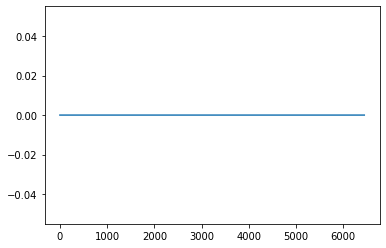

In [62]:
renderer.set_look_at_parameters([170], [30], [0.5])
optimizer = torch.optim.Adam(model.parameters(), 0.001, betas=(0.5, 0.99))
optimizer.zero_grad()
new_vertices = model() 
#model.update.register_hook(lambda grad: print(f"update mean: {grad.mean()}"))
rgb, _, _ = renderer(points=[new_vertices, faces.long()],
                             uv_bxpx2=uv,
                             texture_bx3xthxtw=texture)

#rgb.register_hook(lambda grad: print(f"rgb mean: {grad.mean()}"))
loss = rgb.mean()
print(loss.item())

loss.backward(retain_graph=True)
print(model.update.grad)
print(model.update.grad.shape)
gradient_np = model.update.grad.detach().cpu().numpy()[0]
gradient_line = np.sum(np.abs(gradient_np), axis=1)


plt.plot(gradient_line)
print(np.max(gradient_line))
print(np.min(gradient_line))


In [28]:
renderer.set_look_at_parameters([170],
                                [30],
                                [0.5])

print("vertices.requires_grad:", vertices.requires_grad)
print("faces.requires_grad:", faces.requires_grad)
print("uv.requires_grad:", uv.requires_grad)
print("texture.requires_grad:", texture.requires_grad)
rgb, _, _ = renderer(points=[vertices, faces.long()],
                             uv_bxpx2=uv,
                             texture_bx3xthxtw=texture)

rgb.mean().backward(retain_graph=True)
print(vertices)
# print("rgb.requires_grad:", rgb.requires_grad)

# PERMUTE_BGR = [2, 1, 0]
# rendering_torch_BGR = rgb[:, :, :, PERMUTE_BGR]
# rendering_torch_input = rendering_torch_BGR.permute((0, 3, 1, 2)).float()  - 0.5
# print("rendering_torch_input.requires_grad:", rendering_torch_input.requires_grad)

# paf, heatmap = body_estimation.model(rendering_torch_input)
# print("paf.requires_grad:", paf.requires_grad)
# print("heatmap.requires_grad:", paf.requires_grad)
# #heatmap_wrist = heatmap[0, :, :, :]
# heatmap.register_hook(lambda grad: print("Gradients less than zero:", bool((grad < 0).any())))  

# heatmap.mean().backward(retain_graph=True)
# print(heatmap.grad)

vertices.requires_grad: True
faces.requires_grad: False
uv.requires_grad: False
texture.requires_grad: False
None


/home/ax/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [29]:
heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'front')

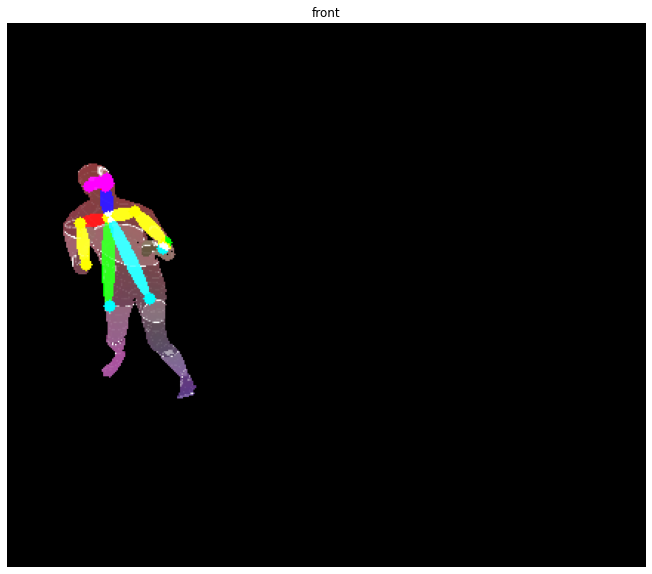

In [40]:
canvas = copy.deepcopy(image)
canvas = util.draw_bodypose(canvas, candidate, subset)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas)
ax.axis('off')
ax.set_title('front')

In [41]:
paf, heatmap = body_estimation.model(rendering_torch_input)

In [42]:
# get r shoudler
heatmap_wrist = heatmap[:, 2, :, :]

In [46]:
heatmap_wrist.mean().backward()

In [48]:
print(vertices.grad)

None
